##Importing Helper's function



In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-01 08:18:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-07-01 08:18:30 (9.99 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##Loading 10% of the food101 dataset

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-07-01 08:18:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 74.125.204.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  27.5MB/s    in 61s     

2024-07-01 08:19:35 (25.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_fo

##Training and test dataset

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Activating ModelCheckpoint call back

In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

##Building the base model

In [26]:
import tensorflow as tf
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

from tensorflow.keras.metrics import TopKCategoricalAccuracy, Precision, Recall
# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy", TopKCategoricalAccuracy(k=5), Precision(), Recall()])

# 10. Fit the model (we use less steps for validation so it's faster)
history_0 = model_0.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(1.0 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "All 101 dataset classes")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/All 101 dataset classes/20240701-090205
Epoch 1/5
237/237 [==============================] - 73s 275ms/step - loss: 3.1976 - accuracy: 0.3168 - top_k_categorical_accuracy: 0.5740 - precision_4: 0.9492 - recall_4: 0.0321 - val_loss: 2.2058 - val_accuracy: 0.4983 - val_top_k_categorical_accuracy: 0.7973 - val_precision_4: 0.9514 - val_recall_4: 0.1224
Epoch 2/5
237/237 [==============================] - 69s 291ms/step - loss: 1.9481 - accuracy: 0.5624 - top_k_categorical_accuracy: 0.8285 - precision_4: 0.9392 - recall_4: 0.1875 - val_loss: 1.7704 - val_accuracy: 0.5693 - val_top_k_categorical_accuracy: 0.8390 - val_precision_4: 0.9183 - val_recall_4: 0.2545
Epoch 3/5
237/237 [==============================] - 65s 275ms/step - loss: 1.5566 - accuracy: 0.6374 - top_k_categorical_accuracy: 0.8725 - precision_4: 0.9402 - recall_4: 0.3156 - val_loss: 1.598

##Evaluate the base model and plot the graph

In [28]:
#Evaluate the model
test_loss, test_accuracy, test_top5_accuracy, test_precision, test_recall = model_0.evaluate(test_data)

790/790 [==============================] - 54s 69ms/step - loss: 1.4499 - accuracy: 0.6240 - top_k_categorical_accuracy: 0.8690 - precision_4: 0.8855 - recall_4: 0.4095


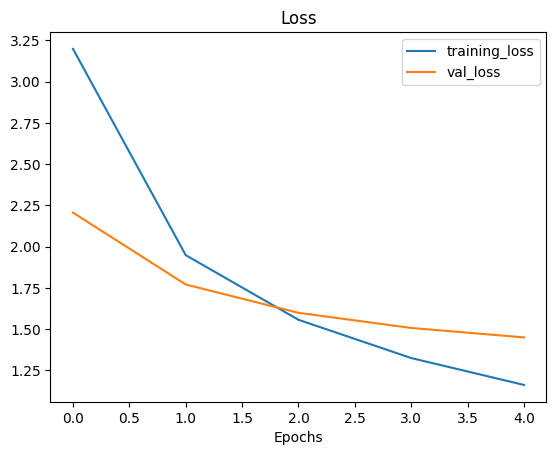

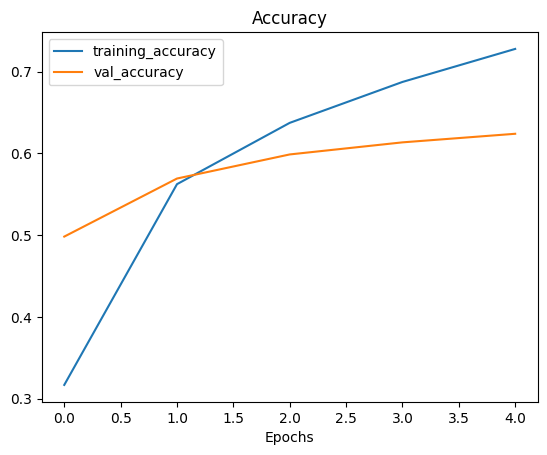

In [27]:
#how does our model training curve looks like
plot_loss_curves(history_0)

##Fine-tuning the model to improve performance

In [17]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [20]:
#Set all layers to trainable
base_model.trainable = True

#Freeeze all layers except the first 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [22]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

##Compile and fit model after fine-tuning

In [23]:
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy", TopKCategoricalAccuracy(k=5), Precision(), Recall()])

# 10. Fit the model (we use less steps for validation so it's faster)
history_1 = model_0.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(1.0 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "All 101 dataset classes")])

Saving TensorBoard log files to: transfer_learning/All 101 dataset classes/20240701-084904
Epoch 1/5
237/237 [==============================] - 85s 321ms/step - loss: 2.6821 - accuracy: 0.3949 - top_k_categorical_accuracy: 0.6521 - precision_3: 0.8543 - recall_3: 0.1401 - val_loss: 1.5717 - val_accuracy: 0.5924 - val_top_k_categorical_accuracy: 0.8573 - val_precision_3: 0.8583 - val_recall_3: 0.3678
Epoch 2/5
237/237 [==============================] - 65s 274ms/step - loss: 1.4287 - accuracy: 0.6442 - top_k_categorical_accuracy: 0.8747 - precision_3: 0.8995 - recall_3: 0.4102 - val_loss: 1.3452 - val_accuracy: 0.6358 - val_top_k_categorical_accuracy: 0.8814 - val_precision_3: 0.8426 - val_recall_3: 0.4755
Epoch 3/5
237/237 [==============================] - 66s 276ms/step - loss: 1.0129 - accuracy: 0.7455 - top_k_categorical_accuracy: 0.9317 - precision_3: 0.9198 - recall_3: 0.5555 - val_loss: 1.2813 - val_accuracy: 0.6521 - val_top_k_categorical_accuracy: 0.8858 - val_precision_3: 0.8

##Evaluate and plot the graph

In [24]:
#Evaluate the model
test_loss, test_accuracy, test_top5_accuracy, test_precision, test_recall = model_0.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.2537 - accuracy: 0.6618 - top_k_categorical_accuracy: 0.8893 - precision_3: 0.8085 - recall_3: 0.5707


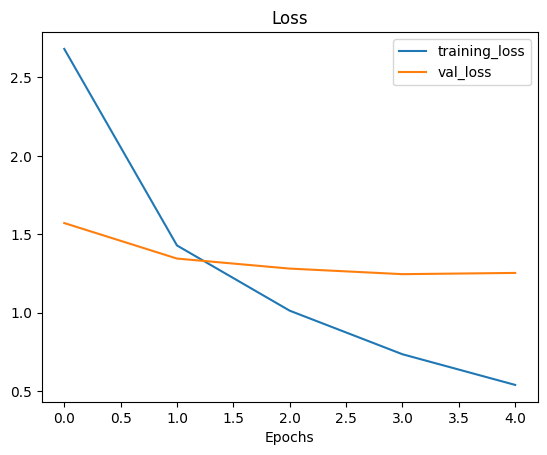

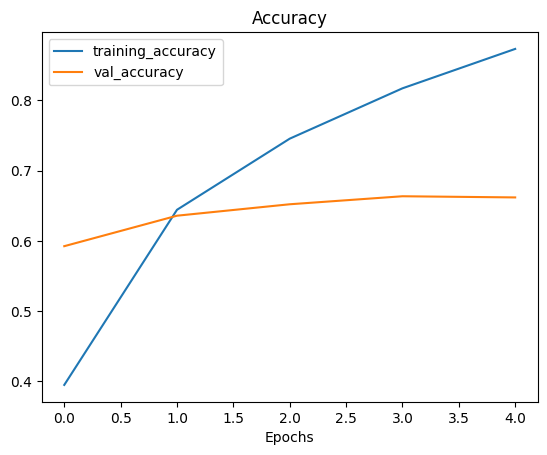

In [25]:
#how does our model training curve looks like
plot_loss_curves(history_1)